# Upper Confidence Bound (UCB) Algorithm

The **Upper Confidence Bound (UCB)** algorithm is a sophisticated approach to the exploration-exploitation trade-off that uses **optimism in the face of uncertainty**. Unlike epsilon-greedy which explores randomly, UCB systematically explores actions based on their uncertainty.


Watch video form 48:45-1:11.
you can keep going (1:43)

In [33]:
from IPython.display import IFrame

IFrame('https://www.youtube.com/embed/aQJP3Z2Ho8U?start=2880', width=800, height=450)


## Installation
First, install the required dependencies with pinned versions for reproducibility.

In [34]:
%%capture
!pip install numpy==1.24.3 matplotlib==3.7.2



### The Core Principle: Optimism Under Uncertainty

The key insight of UCB is simple but powerful:
> "Actions that have been tried less often are more uncertain. We should be optimistic about uncertain actions and give them a chance."

Instead of randomly exploring, UCB adds an **uncertainty bonus** to each action's estimated value. Actions with:
- **High estimated value**: Already look good
- **High uncertainty** (tried rarely): Get a bonus because we don't know much about them

### UCB Action-Selection Rule

At each time step $t$, UCB selects the action that maximizes:

$$A_t = \arg\max_a \left( Q_t(a) + U_t(a) \right)$$

Where:
- $Q_t(a)$ is the **estimated value** of action $a$ (exploitation term)
- $U_t(a)$ is the **uncertainty bonus** (exploration term)

This is called the **Upper Confidence Bound** because $Q_t(a) + U_t(a)$ represents an optimistic upper bound on the true value of action $a$.




Upper Confidence Bound (UCB) Algorithm

### The Uncertainty Bonus

The uncertainty term is defined as:

$$U_t(a) = c\sqrt{\frac{\log t}{N_t(a)}}$$



**Breaking this down:**
- $N_t(a)$: Number of times action $a$ has been selected
  - In denominator → Uncertainty **decreases** as we try action $a$ more
- $\log t$: Total time steps so far
  - Grows slowly → Eventually we stop exploring even rarely-tried actions
  - Ensures all actions get tried infinitely often (as $t \to \infty$)
- $c$: Exploration parameter (typically 1 or 2)
  - Higher $c$ → More exploration
  - Lower $c$ → More exploitation



We adopt the convention that any action with $N_t(a) = 0$ has UCB value $+\infty$ ensuring that each action is selected at least once.

### Why the Square Root and Logarithm?

The formula $\sqrt{\log t / N_t(a)}$ comes from **Hoeffding's inequality** in probability theory. It provides a confidence bound on how far the true mean could be from our estimate, with high probability.

Intuitively:
- $1/N_t(a)$ is the variance of the sample mean
- $\sqrt{\cdot}$ converts variance to standard deviation
- $\log t$ provides the confidence level that grows with time

## Example Calculation

Suppose at time $t = 6$ we have:

**Action 1:**
- $Q_6(1) = 2.0$
- $N_6(1) = 3$ (selected 3 times)
- $U_6(1) = \sqrt{\frac{\log 6}{3}} = \sqrt{\frac{1.79}{3}} \approx 0.77$
- **UCB score** = $2.0 + 0.77 = 2.77$

**Action 2:**
- $Q_6(2) = 2.33$ (from rewards: 0, 3, 4)
- $N_6(2) = 3$ (selected 3 times)
- $U_6(2) = \sqrt{\frac{\log 6}{3}} \approx 0.77$
- **UCB score** = $2.33 + 0.77 = 3.10$

→ **Action 2 is selected** (higher UCB score)

### Value Update Rule

Like epsilon-greedy, UCB updates Q-values using sample averaging:

$$Q_{t+1}(a) = Q_t(a) + \frac{1}{N_t(a)}\left[R_t - Q_t(a)\right]$$

The uncertainty bounds are updated automatically based on $N_t(a)$ and $t$.

### Advantages and Limitations

**Advantages:**
- **Principled exploration**: Explores based on uncertainty, not randomly
- **No hyperparameter tuning**: Works well with default $c=1$ or $c=2$
- **Theoretical guarantees**: Logarithmic regret bound $O(\log t)$
- **Automatic balancing**: Naturally reduces exploration over time
- **Never wastes time**: Always picks the most promising action

**Limitations:**
- **Assumes stationarity**: Works best when reward distributions don't change
- **Slow for many actions**: Must try each action at least once initially
- **No distributional model**: Doesn't model reward distributions (unlike Thompson Sampling)
- **Sensitive to variance**: Assumes similar variance across actions

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from deepmind_bandits import UpperConfidenceBound, GaussianBandits, BanditDataAnalyzer

# Set random seed for reproducibility
np.random.seed(42)

## Environment Setup

We create a Gaussian bandit environment with 4 actions. Each action has a true mean reward (unknown to the agent) and some noise (standard deviation).

**Environment Design:**
- Action 0: Low mean (1.0), low noise - consistently mediocre
- Action 1: High mean (2.0), moderate noise - **optimal action**
- Action 2: Negative mean (-1.0), low noise - clearly bad
- Action 3: Zero mean (0.0), high noise - unpredictable

The agent must learn through interaction which action is best, using the UCB criterion to guide exploration.

In [36]:
# Create bandit environment with Gaussian reward distributions
means = [1.0, 2.0, -1.0, 0.0]
stds = [0.1, 0.2, 0.1, 0.3]
env = GaussianBandits(means, stds)
num_actions = env.num_arms

print(f"Number of actions: {num_actions}")
print(f"True mean rewards: {means}")
print(f"Reward noise (stds): {stds}")
print(f"\nOptimal action: {np.argmax(means)} with mean reward = {max(means):.2f}")
print(f"\nGoal: UCB will systematically explore uncertain actions and exploit the best!")

Number of actions: 4
True mean rewards: [1.0, 2.0, -1.0, 0.0]
Reward noise (stds): [0.1, 0.2, 0.1, 0.3]

Optimal action: 1 with mean reward = 2.00

Goal: UCB will systematically explore uncertain actions and exploit the best!


## Agent Initialization

We create a UCB agent and a data analyzer to track its performance over time.

**Agent Configuration:**
- All Q-values initialized to 0 (neutral starting point)
- Exploration parameter $c = 1.0$ (standard choice)
- Uncertainty bounds initialized to 0 (will be computed on first selection)
- Uses sample-average updates (step size = 1/N)

**How UCB will behave:**
1. **Initially**: All actions have infinite uncertainty (N=0), so each is tried once
2. **Early phase**: High uncertainty bonuses encourage broad exploration
3. **Mid phase**: Uncertainty decreases, good actions get selected more
4. **Late phase**: Optimal action dominates, but occasional exploration continues

In [37]:
# Create UCB agent
agent = UpperConfidenceBound(num_actions=num_actions, initial_q=0.0, c=1.0)

# Create analyzer for tracking performance metrics
analyzer = BanditDataAnalyzer(means, num_actions)

print(f"Agent Configuration:")
print(f"  Exploration parameter c: {agent.c}")
print(f"  Initial Q-values: {agent.Q}")
print(f"  Initial uncertainty bounds: {agent.U}")
print(f"  Initial action counts: {agent.N}")
print(f"\nUCB will automatically balance exploration and exploitation!")

Agent Configuration:
  Exploration parameter c: 1.0
  Initial Q-values: [0. 0. 0. 0.]
  Initial uncertainty bounds: [inf inf inf inf]
  Initial action counts: [0 0 0 0]

UCB will automatically balance exploration and exploitation!


## Training Loop

Now we run the main learning loop for 1000 time steps. At each step:

1. **Compute UCB scores**: For each action $a$, calculate $Q_t(a) + c\sqrt{\log t / N_t(a)}$
2. **Select**: Choose action with highest UCB score (deterministic, unlike epsilon-greedy)
3. **Execute**: Take action in environment, observe reward
4. **Update**: Update Q-value and uncertainty bound
5. **Track**: Record performance metrics

**What to expect:**
- All actions tried at least once initially
- Bad actions quickly ruled out (low Q + small uncertainty)
- Promising actions get more chances (high Q or high uncertainty)
- Optimal action eventually dominates
- No wasted exploration on obviously bad actions

In [38]:
T = 1000  # Number of time steps

for t in range(T):
    # Agent selects action using UCB criterion
    action = agent.select_action()
    
    # Execute action and observe reward from environment
    reward = env.pull_arm(action)
    
    # Update Q-value estimate and uncertainty bound
    agent.update_values(action, reward)
    
    # Track performance for analysis
    analyzer.update_and_analyze(action, reward)

print(f"Training completed: {T} time steps\n")
print(f"Final Q-value estimates:")
for a in range(num_actions):
    error = abs(agent.Q[a] - means[a])
    ucb_score = agent.Q[a] + agent.U[a]
    print(f"  Action {a}: Q = {agent.Q[a]:.3f}, U = {agent.U[a]:.3f}, UCB = {ucb_score:.3f}")
    print(f"            (true = {means[a]:.2f}, error = {error:.3f})")
    
print(f"\nAction selection counts: {agent.N}")
print(f"Total selections: {sum(agent.N)} (should equal {T})")

Training completed: 1000 time steps

Final Q-value estimates:
  Action 0: Q = 1.052, U = 0.833, UCB = 1.884
            (true = 1.00, error = 0.052)
  Action 1: Q = 2.004, U = 0.083, UCB = 2.087
            (true = 2.00, error = 0.004)
  Action 2: Q = -1.055, U = 0.000, UCB = -1.055
            (true = -1.00, error = 0.055)
  Action 3: Q = -0.070, U = 1.177, UCB = 1.107
            (true = 0.00, error = 0.070)

Action selection counts: [  1 997   1   1]
Total selections: 1000 (should equal 1000)


## Results Analysis

Let's analyze how well the UCB agent performed. We'll examine:
- **Q-value convergence**: Did estimates converge to true values?
- **Uncertainty evolution**: How did uncertainty bounds change over time?
- **Action selection**: Did UCB efficiently identify the optimal action?
- **Regret**: How does UCB compare to epsilon-greedy?
- **Cumulative reward**: Total reward accumulated

In [39]:
# Finalize analysis (compute cumulative metrics)
analyzer.finalize_analysis()

### Q-Value Progression Over Time

This plot shows how the agent's Q-value estimates evolved during learning:
- **Solid colored lines**: Q-values for each action over time
- **Dashed lines**: True mean rewards (ground truth)
- **Red arrows**: When the agent switches between actions

**What to look for:**
- Q-values should converge toward true means (dashed lines)
- UCB explores more systematically than epsilon-greedy
- Bad actions (negative rewards) quickly abandoned
- Fewer random switches compared to epsilon-greedy

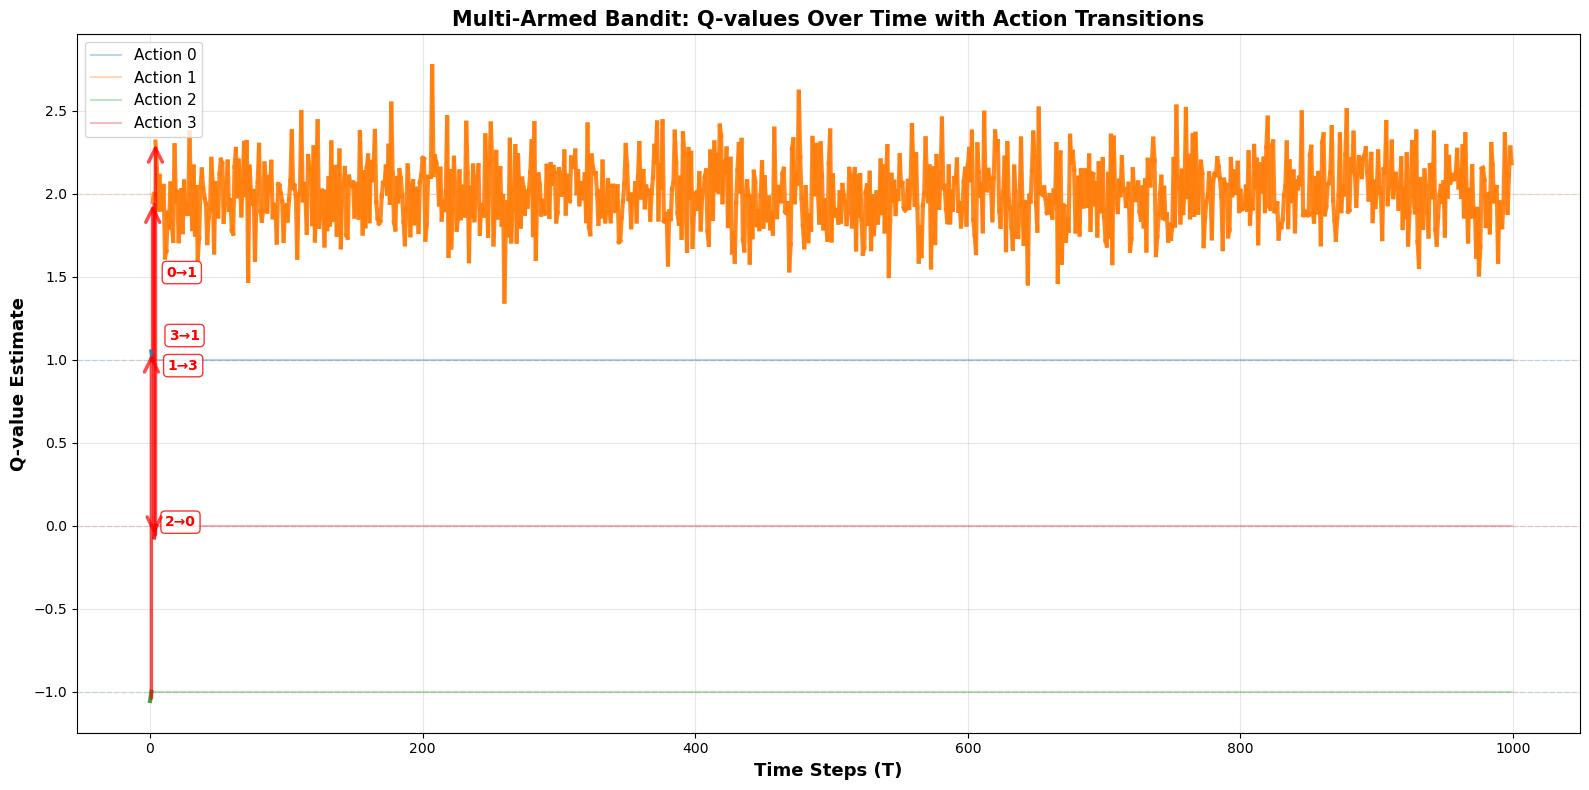


Transitions detected: 4
  Step 1: Action 2 → Action 0
  Step 2: Action 0 → Action 1
  Step 3: Action 1 → Action 3
  Step 4: Action 3 → Action 1


In [40]:
analyzer.plot_Qvalue()

### Cumulative Regret

**Regret** measures the difference between optimal reward and actual reward.

**Key difference from epsilon-greedy:**
- Epsilon-greedy: Regret grows **linearly** (always explores randomly)
- UCB: Regret grows **logarithmically** $O(\log t)$ (exploration decreases over time)

**What to look for:**
- **Slope should flatten**: Unlike epsilon-greedy, UCB's regret growth slows down
- **Lower final regret**: UCB should outperform epsilon-greedy
- **Shape**: Should be sublinear (curve flattens over time)

The logarithmic regret bound is UCB's main theoretical advantage!

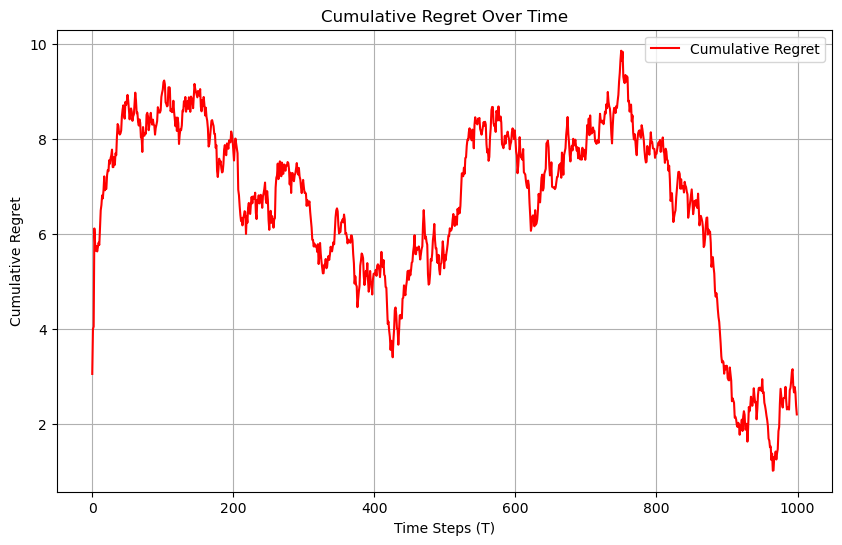

In [41]:
analyzer.plot_regret()

### Cumulative Reward

This shows the total reward accumulated over time:
- **Black line**: Total cumulative reward across all actions
- **Dashed lines**: Cumulative reward per action

**What to look for:**
- Steeper slope = higher reward rate
- Optimal action (action 1) should dominate
- Total reward should grow faster than epsilon-greedy

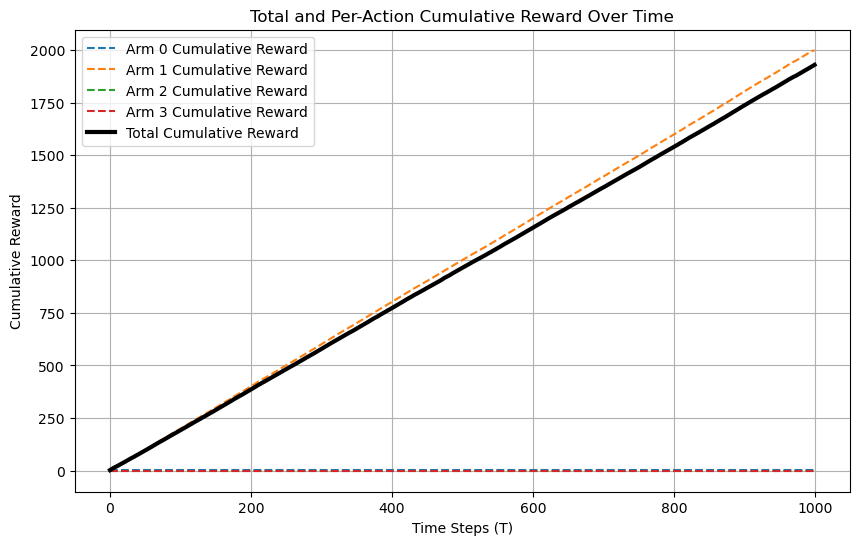

In [42]:
analyzer.plot_cumulative_reward()

## Performance Summary and Analysis

In [43]:
print("=" * 60)
print("UCB PERFORMANCE SUMMARY")
print("=" * 60)

print(f"\nExperiment Parameters:")
print(f"  Total time steps: {T}")
print(f"  Exploration parameter c: {agent.c}")

print(f"\nLearned Q-Values and UCB Scores:")
ucb_scores = agent.Q + agent.U
for a in range(num_actions):
    q_val = agent.Q[a]
    u_val = agent.U[a]
    ucb = ucb_scores[a]
    true_mean = means[a]
    error = abs(q_val - true_mean)
    count = agent.N[a]
    pct = 100 * count / T
    marker = " ← OPTIMAL" if a == np.argmax(means) else ""
    print(f"  Action {a}: Q={q_val:6.3f}, U={u_val:5.3f}, UCB={ucb:6.3f}")
    print(f"            True={true_mean:5.2f}, Error={error:.3f} | "
          f"Selected {count:4d} times ({pct:5.1f}%){marker}")

optimal_action = np.argmax(means)
optimal_selections = agent.N[optimal_action]
optimal_pct = 100 * optimal_selections / T

print(f"\nOptimal Action Performance:")
print(f"  Optimal action: {optimal_action} (true mean = {means[optimal_action]:.2f})")
print(f"  Times selected: {optimal_selections}/{T} ({optimal_pct:.1f}%)")

if optimal_pct >= 85:  # UCB should select optimal action >85% of the time
    print(f"  ✓ Excellent! UCB efficiently identified and exploited optimal action")
elif optimal_pct >= 70:
    print(f"  ✓ Good performance - learning the optimal action")
else:
    print(f"  ⚠ Could improve - may need more time to converge")

print(f"\nRegret Analysis:")
print(f"  Final cumulative regret: {analyzer.regret[-1]:.2f}")
print(f"  Average regret per step: {analyzer.regret[-1]/T:.3f}")
print(f"  Expected regret growth: O(log t) - sublinear")

print(f"\nUncertainty Analysis:")
print(f"  Final uncertainty bounds: {[f'{u:.3f}' for u in agent.U]}")
print(f"  Interpretation: Lower uncertainty = more confident estimates")
print(f"  Optimal action has lowest uncertainty: {agent.U[optimal_action] == min(agent.U)}")

print("\n" + "=" * 60)

UCB PERFORMANCE SUMMARY

Experiment Parameters:
  Total time steps: 1000
  Exploration parameter c: 1.0

Learned Q-Values and UCB Scores:
  Action 0: Q= 1.052, U=0.833, UCB= 1.884
            True= 1.00, Error=0.052 | Selected    1 times (  0.1%)
  Action 1: Q= 2.004, U=0.083, UCB= 2.087
            True= 2.00, Error=0.004 | Selected  997 times ( 99.7%) ← OPTIMAL
  Action 2: Q=-1.055, U=0.000, UCB=-1.055
            True=-1.00, Error=0.055 | Selected    1 times (  0.1%)
  Action 3: Q=-0.070, U=1.177, UCB= 1.107
            True= 0.00, Error=0.070 | Selected    1 times (  0.1%)

Optimal Action Performance:
  Optimal action: 1 (true mean = 2.00)
  Times selected: 997/1000 (99.7%)
  ✓ Excellent! UCB efficiently identified and exploited optimal action

Regret Analysis:
  Final cumulative regret: 2.20
  Average regret per step: 0.002
  Expected regret growth: O(log t) - sublinear

Uncertainty Analysis:
  Final uncertainty bounds: ['0.833', '0.083', '0.000', '1.177']
  Interpretation: Lower 

## Visualize Uncertainty Evolution

Let's track how uncertainty bounds and UCB scores evolved over time. This visualization helps understand UCB's exploration strategy.
 We can plot  $Q_t(a) + U_t(a)$ and $U_t(a)$ with respect to $t$.



In [48]:
# Run a fresh experiment to track uncertainty evolution
np.random.seed(42)
agent_track = UpperConfidenceBound(num_actions=num_actions, c=1.0)
uncertainty_history = [[] for _ in range(num_actions)]
q_history = [[] for _ in range(num_actions)]

T_track = 200
for t in range(T_track):
    action = agent_track.select_action()
    reward = env.pull_arm(action)
    agent_track.update_values(action, reward)
    
    # Track Q-values and uncertainty for all actions
    for a in range(num_actions):
        q_history[a].append(agent_track.Q[a])
        uncertainty_history[a].append(agent_track.U[a])




As we plot $U_t(a)$, we observe that, except for action $a = 1$, the values remain constant, while \(U_t(1)\) decreases over time. Despite this, $Q_t(1) + U_t(1)$ remains the largest among all actions.

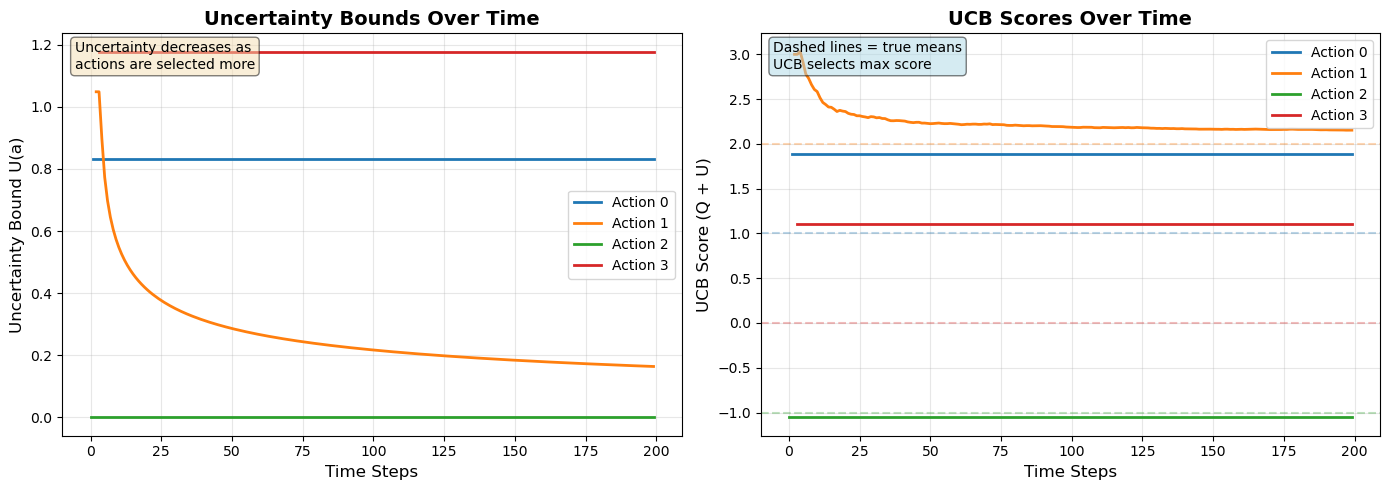


Key observations:
- Left plot: Uncertainty (exploration bonus) decreases as actions are tried
- Right plot: UCB scores combine estimates + uncertainty
- Bad actions quickly ruled out (low Q, low uncertainty)
- Optimal action dominates once uncertainty is resolved


In [49]:
# Plot uncertainty bounds and UCB scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Uncertainty bounds over time
for a in range(num_actions):
    ax1.plot(uncertainty_history[a], label=f'Action {a}', linewidth=2)
ax1.set_xlabel('Time Steps', fontsize=12)
ax1.set_ylabel('Uncertainty Bound U(a)', fontsize=12)
ax1.set_title('Uncertainty Bounds Over Time', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.text(0.02, 0.98, 'Uncertainty decreases as\nactions are selected more', 
         transform=ax1.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Right plot: UCB scores over time
for a in range(num_actions):
    ucb_vals = np.array(q_history[a]) + np.array(uncertainty_history[a])
    ax2.plot(ucb_vals, label=f'Action {a}', linewidth=2)
    ax2.axhline(y=means[a], color=f'C{a}', linestyle='--', alpha=0.3, linewidth=1.5)
ax2.set_xlabel('Time Steps', fontsize=12)
ax2.set_ylabel('UCB Score (Q + U)', fontsize=12)
ax2.set_title('UCB Scores Over Time', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.text(0.02, 0.98, 'Dashed lines = true means\nUCB selects max score', 
         transform=ax2.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.show()

print("\nKey observations:")
print("- Left plot: Uncertainty (exploration bonus) decreases as actions are tried")
print("- Right plot: UCB scores combine estimates + uncertainty")
print("- Bad actions quickly ruled out (low Q, low uncertainty)")
print("- Optimal action dominates once uncertainty is resolved")
     



## Key Takeaways

**What we learned:**
1. ✅ UCB uses **optimism under uncertainty** for principled exploration
2. ✅ Uncertainty bounds decrease with $1/\sqrt{N_t(a)}$ - more samples = more confidence
3. ✅ UCB achieves **logarithmic regret** $O(\log t)$ - much better than linear!
4. ✅ No hyperparameter tuning needed - works well with $c=1$ or $c=2$
5. ✅ Automatically reduces exploration over time (unlike fixed epsilon)

**Comparison with Epsilon-Greedy:**
- **Exploration**: UCB explores systematically (uncertainty-based) vs. epsilon-greedy (random)
- **Regret**: UCB has $O(\log t)$ regret vs. epsilon-greedy has $O(t)$ regret  
- **Efficiency**: UCB doesn't waste time on obviously bad actions
- **Adaptability**: UCB automatically reduces exploration; epsilon-greedy needs manual decay

**When to use UCB:**
- ✅ When you want principled exploration without random noise
- ✅ When regret minimization is important
- ✅ In stationary environments (reward distributions don't change)
- ✅ When you want theoretical guarantees
- ✅ As a strong baseline before trying more complex methods

**Limitations to consider:**
- ⚠️ Assumes stationary rewards (use discounted UCB for non-stationary)
- ⚠️ Sensitive to reward scale (normalize rewards if needed)
- ⚠️ Doesn't model full reward distributions (Thompson Sampling does)

**Next steps:**
- Try different values of $c$ (exploration parameter)
- Compare performance with epsilon-greedy on same problem
- Explore Thompson Sampling for Bayesian approach
- Study UCB variants: UCB1-Tuned, Discounted UCB, etc.

Created by Joseph Santarcangelo
Licensed under Creative Commons Attribution (CC BY). Free to share and adapt with attribution.